# Tutorial: PyMoosh with Nevergrad - Benchmarking optimizers

In [1]:
# install dependecies
!pip install -U pymoosh
!pip install -U nevergrad

## load modules

In [2]:
import time
import copy

import nevergrad as ng
import matplotlib.pyplot as plt
import PyMoosh as pm
import numpy as np
from tqdm import tqdm

## preparation define geometry & cost functions; setup

We start by defining the geometric model helper, the cost function and set up the optimization problem and its parametrization.

In [3]:
def setup_structure(thick_list, mat_env, mat1, mat2):
    """helper to create pymoosh structure object, alternating 2 materials

    Args:
        thick_list (list): list of thicknesses, top layer first
        mat_env (float): environment ref. index
        mat1 (float): material 1 ref. index
        mat2 (float): material 2 ref. index

    Returns:
        PyMoosh.structure: multi-layer structure object
    """
    thick_list = list(
        thick_list)  # convert to list for convenience when stacking layers
    n = len(thick_list)

    materials = [mat_env**2, mat1**2, mat2**2]  # permittivities!
    # periodic stack. first layer: environment, last layer: substrate
    stack = [0] + [2, 1] * (n//2) + [2]
    thicknesses = [0.] + thick_list + [0.]

    structure = pm.Structure(
        materials, stack, np.array(thicknesses), verbose=False)

    return structure


# ------- the optimization target function -------
def cost_minibragg(x, mat_env, mat1, mat2, eval_wl):
    """ cost function: maximize reflectance of a layer-stack

    Args:
        x (list): thicknesses of all the layers, starting with the upper one.

    Returns:
        float: 1 - Reflectivity at target wavelength
    """
    structure = setup_structure(x, mat_env, mat1, mat2)

    # the actual PyMoosh reflectivity simulation
    _, R = pm.coefficient_I(structure, eval_wl, 0., 0)
    cost = 1 - R

    return cost


# ------- define "mini-bragg" optimization problem
nb_layers = 10     # number of layers of full stack
target_wl = 600.0  # nm
mat_env = 1.0      # materials: ref. index
mat1 = 1.4
mat2 = 1.8
min_thick = 0      # no negative thicknesses
max_thick = target_wl / (2 * mat1)  # lambda/2n


# ------- setup the parametrization
# wrap free and fixed arguments


## Running multiple optimizations

Now we run the optimization with several optimizers in an attempt to find the best suited algorithm for our problem.

*Note*: the testing of several optimizers could be very easily parallelized via multiprocessing.

In [4]:
budget = 20 * nb_layers     # stop criterion: allowed number of evaluations
N_repet_each = 7 # how often to repeat the run with each optimizer

# iterate through list of algorithms to use
list_optims = ["BFGS", "CMA", "QODE", "DE", "NGOpt"]

# init results container dict
hist_cost = {}
hist_best_f = {}
for optim_name in list_optims:
    hist_cost[optim_name] = []
    hist_best_f[optim_name] = []

# perform optimizations
for optim_name in list_optims:
    print('running optimizer: "{}"'.format(optim_name))

    # run the optimizer multiple times
    t0 = time.time()
    for k in tqdm(range(N_repet_each)):

        # parametrization: define the free parameters
        args_geo_ng = ng.p.Array(
            #init=[min_thick]*nb_layers,
            shape=(nb_layers,),
            lower=min_thick,     # lower and upper bounds for the parameters
            upper=max_thick,
        )

        instru = ng.p.Instrumentation(
            # --- optimization args (multilayer-geometry)
            x=args_geo_ng,
            # --- additional, fixed args
            mat_env=mat_env,
            mat1=mat1,
            mat2=mat2,
            eval_wl=target_wl,
        )
         # initialize the optimizer
        optimizer = ng.optimizers.registry[optim_name](instru, budget)

        # init tracking values
        best_f = float("inf") # container for best solution
        yval = []             # container for convergence curve

        # the actual optimization loop
        for k in range(budget):
            x = optimizer.ask()   # get suggestion for new test structure

            y = cost_minibragg(**x.value[1]) # eval. the optimizer's suggestion
            optimizer.tell(x, y)  # tell the cost to the optimizer

            if y < best_f:
                best_f = y
            yval.append(best_f)

        # add results of run to history
        hist_cost[optim_name].append(yval)
        hist_best_f[optim_name].append(best_f)


running optimizer: "BFGS"


100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


running optimizer: "CMA"


100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


running optimizer: "QODE"


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


running optimizer: "DE"


100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


running optimizer: "NGOpt"


100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


## Convergence plots

We plot the convergence of the different optimizers.

 - All individual optimizer runs are plotted by thin dashed lines.
 - The thick line represents the median cost of all repeated runs of an optimizer.
 - The colored shaded are corresponds to the upper and lower quartile of the cost values of the runs, giving an indication of the stability of the convergence.

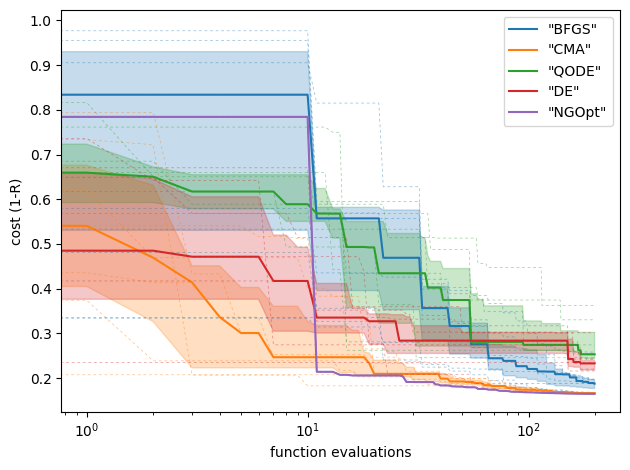

In [5]:
colors = [f'C{i}' for i in range(10)]

for i_opt, k in enumerate(hist_cost):
    for i, convergence in enumerate(hist_cost[k]):
        plt.plot(convergence, color=colors[i_opt], lw=0.5, alpha=0.5, dashes=[4,4])

    plt.plot(np.median(hist_cost[k], axis=0), color=colors[i_opt], label=f'"{k}"')
    plt.fill_between(np.arange(len(hist_cost[k][0])),
                     np.quantile(hist_cost[k], 0.25, axis=0),
                     np.quantile(hist_cost[k], 0.75, axis=0),
                     color=colors[i_opt],
                     alpha=0.25)

plt.xscale('log')

plt.xlabel('function evaluations')
plt.ylabel('cost (1-R)')
plt.legend()

plt.tight_layout()
plt.show()


## plot the consistency test

Now we plot the best cost values of all individual runs in ascending order on a line to test how reproducibile the optimizers obtain their results.
Ideally, we get a flat line with a small value, in which case all optimization repetitions obtained the same result.

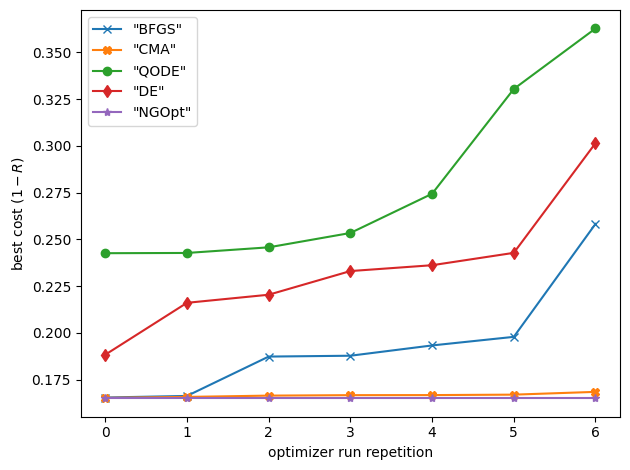

In [7]:
colors = [f'C{i}' for i in range(10)]
markers = ['x', 'X', 'o', 'd', '*', 'D', '+']

for i_opt, k in enumerate(hist_best_f):
    plt.plot(np.sort(hist_best_f[k]), color=colors[i_opt], marker=markers[i_opt], label=f'"{k}"')

plt.xlabel('optimizer run repetition')
plt.ylabel('best cost ($1-R$)')

plt.legend()
plt.tight_layout()
plt.show()